<a href="https://colab.research.google.com/github/buzzerbeater1021/jax-tutorial/blob/main/jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import jax.numpy as jnp
import numpy as np
# transform functions
from jax import grad, jit, vmap, pmap

# jax low level api
from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

In [25]:
import numpy as np

In [8]:
x_jnp = jnp.linspace(0, 10, 1000)


In [9]:
print(x_jnp.shape)

(1000,)


In [10]:
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)

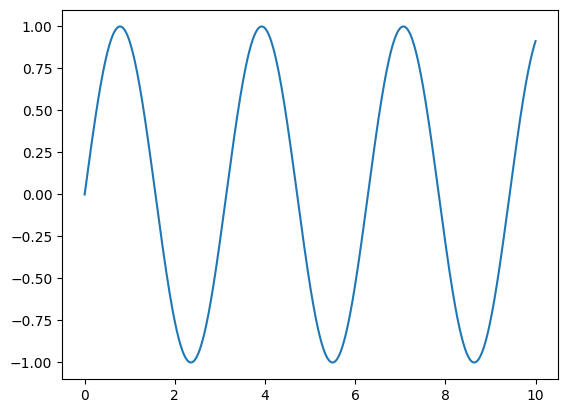

In [11]:
plt.plot(x_jnp, y_jnp)

In [12]:
# Jax arrays are immutable (functional programming paradigm)
x = jnp.arange(10)

In [13]:
x

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [14]:
# solution
index = 0
y = x.at[index].set(10)
y

Array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int32)

In [15]:
# Jax handles random numbers differently
seed = 0
key = random.PRNGKey(seed)
# mean 0, standard deviation is 1
x = random.normal(key, (10,))
print(type(x), x)

<class 'jaxlib._jax.ArrayImpl'> [ 1.6226422   2.0252647  -0.43359444 -0.07861735  0.1760909  -0.97208923
 -0.49529874  0.4943786   0.6643493  -0.9501635 ]


In [16]:
# Jax is AI accelerator agnostic. Same code runs everywhere.

size = 3000

# Data is automatically pushed to the AI accelerator
# No more need for ".to(device)" from pytorch

x_jnp = random.normal(key, (3000, 3000), dtype=jnp.float32)

In [17]:
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()


12.4 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
# on cpu
x_np = np.random.normal(size=(size, size)).astype(np.float32)
x_np_device = device_put(x_np)
print(x_np_device.device)

cuda:0


In [19]:
import jax

print(jax.devices())

[CudaDevice(id=0)]


In [20]:
tmp = jnp.dot(x_jnp, x_jnp.T)
# ...code, at this point, the code aboe just delegrates to the accelerator, this line of code will immediately run. thats why it needes block_until_ready above.

# Jax transform functions

`jit()` compiles your functions using xla and caches them -> speed

In [30]:
# wesimple helper visualization func
def visualize_fn(fn, l=-10, r=10, n=1000):
  x = np.linspace(l, r, num=n)
  y = fn(x)
  plt.plot(x, y); plt.show()

In [31]:
# define a function

def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x >0, x, alpha * jnp.exp(x) - alpha)

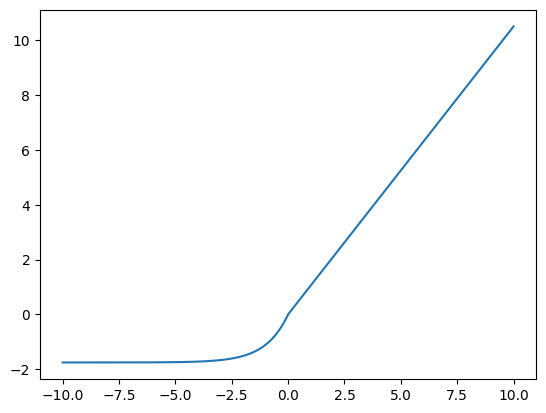

In [32]:
selu_jit = jit(selu) # compile it
visualize_fn(selu_jit)

In [33]:
# benchmark non-jit vs jit version
data = random.normal(key, (1000000,))

print('non-jit version')
%timeit selu(data).block_until_ready()

print('jit version')
%timeit selu_jit(data).block_until_ready()

non-jit version
1.25 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit version
192 µs ± 45.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# grad()

differentation can be:
- manual
- symbolic
- numeric
- automatic (jax)

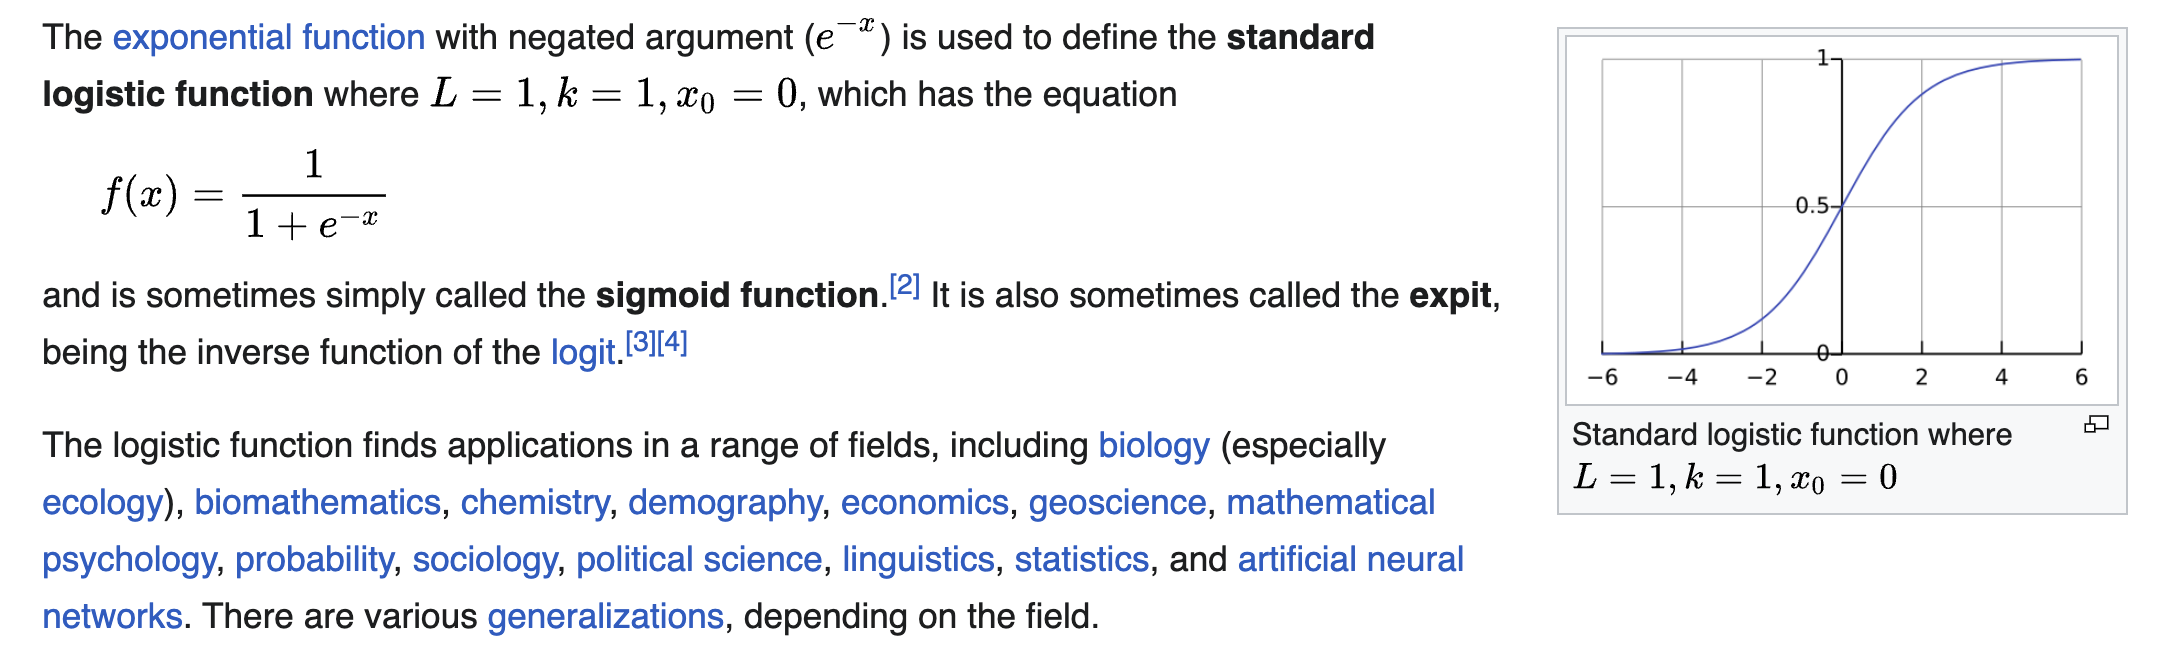

In [40]:
# first example (automatic diff)
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x = jnp.arange(3.)
loss = sum_logistic # rename it to give it some semantics

# by default grad calculates the derivative of a fn w.r.t. 1st parameter
# here we bundled inputs into a 1st param so it doesn't matter
grad_loss = grad(loss)
print(grad_loss(x))

[0.25       0.19661194 0.10499357]


In [41]:
# now sum square
def sum_square(x):
  return jnp.sum(x**2) # derivative would be x1*2 + x2*2 + x3*2

x = jnp.arange(3.)
print(x)
loss = sum_square
grad_loss = grad(loss)
print(grad_loss(x))

[0. 1. 2.]
[0. 2. 4.]


In [43]:
# numeric diff (to double check that autodiff works correctly)

def finite_differences(f, x):
  eps = 1e-3
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps) for v in jnp.eye(len(x))])